# 1. Overview

In [11]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import decomposition
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, plot_roc_curve ,plot_confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [3]:
df = pd.read_csv('data/tele-churn.csv')

In [52]:
df['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

# Categorical Target
1. Binary:True/False(bool)
2. Yes, 86% non-churned, 14% churned 
    - going to try SMOTE and class_weight for a base model
3. Business Problem:
    - Telecom Company wants to stop cut down on costly spending that is spent on campaigns targeting customers that are not liekly to churn and focus on customers that are will actually churn
4. Inference:
    - Will want to provide insights into the features that have the biggest impact on churn.
3. Evaluation metric:
    - The most important metric is **precision** as we are trying to reduce false positives. 
    - Will also want to consider **recall** so that we can show that we are accurately predicting positive cases 
    - Will use ROC-AUC since to map performance

$\begin{bmatrix}
TN & FP \\
FN & TP
\end{bmatrix}$

tn = customer predicted **no-churn** and it's **true**

fp = customer predicted **churn** and it's **false**

fn = customer predicted **no-churn** and it's **false**

tp = customer predicted **churn** and it's **true**

# 2. EDA → Explore your dataset and features

In [ ]:
df.info()

In [ ]:
df.describe()

# Only considering features that deal with customer performance and customer plan

# 3. Valedation Procedure

## &darr; &darr; cross_val_score to print pipeline model cv summaries &darr; &darr;

- **class ModelwithCV( )&trade;**  by Flatiron School 

In [4]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring='precision')
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} precision
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

### function for quick model iteration results

In [5]:
def print_cv_results(model, X_train, y_train):
    model_name = str(type(model).__name__)
    cv_summary = ModelWithCV(model, model_name=model_name, X=X_train, y=y_train).print_cv_summary()
    y_pred = model.predict(X_train)
    precision = precision_score(y_train, y_pred)
    print(f"CV Results for `{model_name}` model:\n{cv_summary}\nPrecision score: {precision}")

#### &darr;&darr; Train test split &darr; &darr;

In [6]:
X = df.drop(columns=['churn', 'phone number', 'area code', 'state'], axis=1)
y = df['churn']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 4. Pipeline 

In [7]:
subpipe_num = Pipeline(steps=[('ss', StandardScaler())])



subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])



num_cols = ['account length','number vmail messages', 'total day minutes', 'total day calls',
           'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge',
           'total night minutes', 'total night calls', 'total night charge', 'total intl minutes',
           'total intl calls', 'total intl charge', 'customer service calls']



cat_cols = ['international plan', 'voice mail plan']



CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, num_cols),
                                     ('subpipe_cat', subpipe_cat, cat_cols)],
                       remainder='passthrough')



X_train_ct = CT.fit_transform(X_train)
X_test_ct = CT.transform(X_test)



CT.fit_transform(X_train).shape, CT.fit_transform(X_test).shape

((2333, 19), (1000, 19))

# 5. Model Iteration

### I. dummy model

In [8]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train_ct, y_train)
y_pred = dummy_clf.predict(X_train_ct)

print_cv_results(dummy_clf, X_train, y_train)

CV Results for `DummyClassifier` model:
            0.15000 ± 0.03590 precision
        
CV Results for `DummyClassifier` model:
None
Precision score: 0.12571428571428572


### II. SMOTE vs class_weight base model

In [ ]:
base_smote = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42, sampling_strategy=.19)),
    ('smotetree', DecisionTreeClassifier(random_state=42))
])

base_smote.fit(X_train, y_train)

print_cv_results(base_smote, X_train, y_train)

In [ ]:
base_class = ImPipeline(steps=[
    ('ct', CT),
    ('classtree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])


base_class.fit(X_train, y_train)

print_cv_results(base_class, X_train, y_train)

### III. part 1 Iterating base_class

In [ ]:
params = {
    'classtree__criterion': ['gini', 'entropy'],
    'classtree__splitter': ['best', 'random'],
    'classtree__max_depth': [None, 10, 20, 30],
    'classtree__min_samples_split': [2, 5, 10],
    'classtree__min_samples_leaf': [1, 2, 4],
    'classtree__min_weight_fraction_leaf': [0.0, 0.5],
    'classtree__max_features': [None, 'auto', 'sqrt', 'log2'],
    'classtree__max_leaf_nodes': [None, 5, 10, 20],
    'classtree__min_impurity_decrease': [0.0, 0.1, 0.2],
    'classtree__splitter': ['best', 'random'],
    'classtree__ccp_alpha': [0.0, 0.2, 0.4]
}
gs1 = GridSearchCV(estimator=base_class,
                 param_grid=params,
                 cv=10, verbose=1, n_jobs=-1, scoring='precision')

In [ ]:
gs1.fit(X_train, y_train)

In [ ]:
gs1.best_params_

In [ ]:
class_2 = ImPipeline(steps=[
    ('ct', CT),
    ('classtree', DecisionTreeClassifier(random_state=42,
                                         class_weight='balanced',
                                        criterion='entropy'))
])


class_2.fit(X_train, y_train)

print_cv_results(class_2, X_train, y_train)

In [ ]:
params = {
    'classtree__max_depth': [None, 1, 3, 5, 7, 8],
    'classtree__max_leaf_nodes': [None, 1, 3, 5, 7, 8],
    'classtree__min_samples_split': [None, 1, 3, 5, 7, 8]
}
    
gs2 = GridSearchCV(estimator=class_2,
                 param_grid=params,
                 cv=10, verbose=1, n_jobs=-1, scoring='precision')

In [ ]:
gs2.fit(X_train, y_train)

In [ ]:
gs2.best_params_

In [ ]:
class_3 = ImPipeline(steps=[
    ('ct', CT),
    ('classtree', DecisionTreeClassifier(random_state=42,
                                         class_weight='balanced',
                                        criterion='entropy',
                                        min_samples_split=3))
])


class_3.fit(X_train, y_train)

print_cv_results(class_3, X_train, y_train)

### III. part 2 Iterating SMOTE 
- **(created later after I found out that adjusting the sampling strategy of SMOTE greatly improved the model over the class_weight model)**

In [ ]:
params = {
    'smotetree__criterion': ['gini', 'entropy'],
    'smotetree__splitter': ['best', 'random'],
    'smotetree__max_depth': [None, 2, 20, 40],
    'smotetree__min_samples_split': [2, 3, 6, 9],
    'smotetree__min_samples_leaf': [1, 2, 4],
    'smotetree__min_weight_fraction_leaf': [0.0, 0.25, 0.5],
    'smotetree__max_features': [None, 'auto', 'sqrt', 'log2'],
    'smotetree__max_leaf_nodes': [None, 5, 10, 20],
    'smotetree__min_impurity_decrease': [0.0, 0.1, 0.2],
    'smotetree__splitter': ['best', 'random'],
    'smotetree__ccp_alpha': [0.0, 0.1, 0.2]
}
gsb1 = GridSearchCV(estimator=base_smote,
                 param_grid=params,
                 cv=10, verbose=1, n_jobs=-1, scoring='precision')

In [ ]:
gsb1.fit(X_train, y_train)

In [ ]:
gsb1.best_params_

In [ ]:
smote2 = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42, sampling_strategy=.19)),
    ('smotetree', DecisionTreeClassifier(random_state=42,
                                         criterion='entropy',
                                         min_samples_leaf=4,
                                         max_leaf_nodes=20,))])

smote2.fit(X_train, y_train)

print_cv_results(smote2, X_train, y_train)

### IV. Ensemble Models

### Random Forest part 1 (base prior to SMOTE)

In [ ]:
forest1 = ImPipeline(steps=[
    ('ct', CT),
    ('classtree', RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        min_samples_split=3,
                                        random_state=42))])

forest1.fit(X_train, y_train)
print_cv_results(forest1, X_train, y_train)

In [ ]:
params ={
    'forest__n_estimators': [100, 200, 300, 600],
    'forest__max_depth': [None, 2, 5, 7, 10, 20],
    'forest__max_samples': [None, 0.5, 0.8],
    'forest__bootstrap': [True, False],
    'forest__oob_score': [True, False]    
}

gsf1 = GridSearchCV(estimator=forest1,
                 param_grid=params,
                 cv=10, verbose=1, n_jobs=-1, scoring='precision')

In [ ]:
gsf1.fit(X_train, y_train)

In [ ]:
gsf1.best_params_

In [ ]:
forest2 = ImPipeline(steps=[
    ('ct', CT),
    ('forest', RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        min_samples_split=3,
                                        random_state=42,
                                        max_samples= 0.5, 
                                        oob_score= True,))])

forest2.fit(X_train, y_train)
print_cv_results(forest2, X_train, y_train)

In [ ]:
params2 = {
  'forest__min_samples_split': [3, 5, 7],
  'forest__max_features': [0.3, 0.5, 0.7],
  'forest__n_estimators': [50, 100, 200]
}

gsf2 = GridSearchCV(estimator=forest2,
                 param_grid=params2,
                 cv=10, verbose=1, n_jobs=-1, scoring='precision')

In [ ]:
gsf2.fit(X_train, y_train)

In [ ]:
gsf2.best_params_

In [ ]:
forest3 = ImPipeline(steps=[
    ('ct', CT),
    ('forest', RandomForestClassifier(class_weight='balanced',
                                        min_samples_split=3,
                                        random_state=42,
                                        max_samples= 0.5, 
                                        oob_score= True,
                                        n_estimators=200,
                                        max_features= 0.3))])

forest3.fit(X_train, y_train)
print_cv_results(forest3, X_train, y_train)

In [ ]:
forest4 = ImPipeline(steps=[
    ('ct', CT),
    ('forest', RandomForestClassifier(criterion='entropy',
                                        min_samples_split=3,
                                        random_state=42,
                                        max_samples= 0.5, 
                                        oob_score= True,
                                        n_estimators=200,
                                        max_features= 0.3))])

forest4.fit(X_train, y_train)
print_cv_results(forest4, X_train, y_train)

### Random Forest part 2 SMOTE

In [ ]:
forests1 = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42, sampling_strategy=0.19)),
    ('forest', RandomForestClassifier(random_state=42))])

forests1.fit(X_train, y_train)
print_cv_results(forests1, X_train, y_train)

In [ ]:
param_sm = {
    'forest__n_estimators': [175, 200, 225],
    'forest__max_depth': [None, 5, 15],
    'forest__min_samples_split': [2, 4, 8],
    'forest__min_samples_leaf': [2, 3, 4],
    'forest__min_weight_fraction_leaf': [0.0, 0.2],
    'forest__max_features': ['auto', "sqrt", "log2"],
    'forest__max_leaf_nodes': [None, 3, 5],
    'forest__min_impurity_decrease': [0.0, 0.1, 0.2],
    'forest__max_samples': [None, 3, 7, 10]
}

gsfs1 = GridSearchCV(estimator=forests1,
                 param_grid=param_sm,
                 cv=5, verbose=1, n_jobs=-1, scoring='precision')

In [ ]:
gsfs1.fit(X_train, y_train)

In [ ]:
gsfs1.best_params_

In [ ]:
forests2 = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42, sampling_strategy=0.75, k_neighbors=1)),
    ('forest', RandomForestClassifier(random_state=42,
                                      n_estimators=200,
                                      max_depth= 15,
                                      min_samples_leaf=3))])

forests2.fit(X_train, y_train)
print_cv_results(forests2, X_train, y_train)

In [ ]:
param_sm2 = {
'forest__bootstrap':[True, False],
'forest__oob_score':[False, True],
'forest__warm_start':[False, True],
'forest__criterion':['gini', 'entropy'],
'forest__min_weight_fraction_leaf': [0.0, 0.1, 0.3],
'forest__min_samples_split': [1, 2, 3],
}

gsfs2 = GridSearchCV(estimator=forests2,
                 param_grid=param_sm2,
                 cv=10, verbose=2, n_jobs=-1, scoring='precision')

In [ ]:
gsfs2.fit(X_train, y_train)

In [ ]:
gsfs2.best_params_

In [ ]:
forests3 = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42, n_jobs=-1,sampling_strategy=0.9, k_neighbors=1)),
    ('forest', RandomForestClassifier(random_state=42,
                                      n_estimators=200,
                                      min_samples_leaf=3,
                                      max_depth= 15,
                                      n_jobs=-1,
                                      criterion= 'entropy'))])

forests3.fit(X_train, y_train)
print_cv_results(forests3, X_train, y_train)

### XGBoost

In [ ]:
from xgboost import XGBClassifier

forest_xgb = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42, n_jobs=-1, sampling_strategy=0.19, k_neighbors=1)),
    ('xgb', XGBClassifier(tree_method='gpu_hist', random_state=42))
])

forest_xgb.fit(X_train, y_train)
print_cv_results(forest_xgb, X_train, y_train)

In [ ]:
xgb_params = {
    'xgb__n_estimators': [100, 175, 200, 225],
    'xgb__max_depth': [None, 5, 10, 15, 20],
    'xgb__learning_rate':[0.01, 0.05, 0.1, 0.15],
}

gsxgb1 = GridSearchCV(estimator=forest_xgb,
                 param_grid=xgb_params,
                 cv=10, verbose=2, n_jobs=-1, scoring='precision')

In [ ]:
gsxgb1.fit(X_train, y_train)

In [ ]:
gsxgb1.best_params_

In [ ]:
forest_xgb2 = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42, n_jobs=-1, sampling_strategy=0.42, k_neighbors=1)),
    ('xgb', XGBClassifier(tree_method='gpu_hist',
                         random_state=42,
                         learning_rate=0.05,
                         max_depth=5,
                         n_estimators=155))
])

forest_xgb2.fit(X_train, y_train)
print_cv_results(forest_xgb2, X_train, y_train)

In [ ]:
forest_xgb2

### ExtraTreeClassifier

In [10]:
extra_tre = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42, n_jobs=-1, sampling_strategy=0.19, k_neighbors=1)),
    ('xtra', ExtraTreesClassifier(random_state=42,
                                 criterion='entropy'))
])

extra_tre.fit(X_train, y_train)
print_cv_results(extra_tre, X_train, y_train)

NameError: name 'ExtraTreesClassifier' is not defined

In [ ]:
param_ex = {
    'xtra__n_estimators': [175, 200, 225],
    'xtra__max_depth': [None, 5, 15],
    'xtra__min_samples_split': [2, 4, 8],
    'xtra__min_samples_leaf': [2, 3, 4],
    'xtra__min_weight_fraction_leaf': [0.0, 0.2],
    'xtra__max_features': ['auto', "sqrt", "log2"],
    'xtra__max_leaf_nodes': [None, 3, 5],
    'xtra__min_impurity_decrease': [0.0, 0.1, 0.2],
    'xtra__max_samples': [None, 3, 7, 10]
}

gsxt = GridSearchCV(estimator=extra_tre,
                 param_grid=param_ex,
                 cv=10, verbose=1, n_jobs=-1, scoring='precision')

In [ ]:
gsxt.fit(X_train, y_train)

In [ ]:
gsxt.best_params_

In [ ]:
extra_tre2 = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42, n_jobs=-1, sampling_strategy=0.22, k_neighbors=2)),
    ('xtra', ExtraTreesClassifier(random_state=42,
                                 criterion='entropy',
                                 n_estimators=130,
                                 max_depth=5,
                                 min_samples_leaf=2))
])

extra_tre2.fit(X_train, y_train)
print_cv_results(extra_tre2, X_train, y_train)

# V. Final Model: ExtraTreeClassifier

In [12]:
final_model_train = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42, n_jobs=-1, sampling_strategy=0.22, k_neighbors=2)),
    ('xtra', ExtraTreesClassifier(random_state=42,
                                 criterion='entropy',
                                 n_estimators=130,
                                 max_depth=5,
                                 min_samples_leaf=2))
])

final_model_train.fit(X_train, y_train)
print_cv_results(final_model_train, X_train, y_train)

CV Results for `Pipeline` model:
            0.97321 ± 0.05372 precision
        
CV Results for `Pipeline` model:
None
Precision score: 0.984375


In [16]:
final_model.score(X_test, y_test)

0.876

In [12]:
final_model = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42, n_jobs=-1, sampling_strategy=0.22, k_neighbors=2)),
    ('xtra', ExtraTreesClassifier(random_state=42,
                                 criterion='entropy',
                                 n_estimators=130,
                                 max_depth=5,
                                 min_samples_leaf=2))
])


final_model.fit(X_train, y_train)


y_pred = final_model.predict(X_test)


print(precision_score(y_test, y_pred))
print(cross_val_score(final_model, X_test, y_test, cv=5, scoring='precision').mean())

1.0
0.9099999999999999


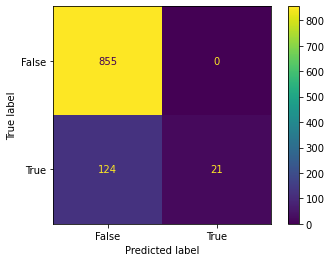

In [13]:
plot_confusion_matrix(final_model, X_test, y_test);

$\begin{bmatrix}
TN & FP \\
FN & TP
\end{bmatrix}$

In [ ]:
final confusion matrix:
True_Negative = 855
False_Negative = 124
False_Positive= 0
True_Positive = 21

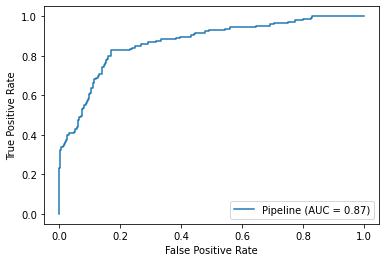

In [23]:
plot_roc_curve(final_model, X_test, y_test);

In [28]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_pred), 2)} \n
Our final model's recall on the test set is {round(recall_score(y_test, y_pred), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_pred), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_pred), 2)} \n
Our final model's roc_auc score on the test is {round(roc_auc_score(y_test, y_pred), 2)}.
""")


Our final model's accuracy on the test set is 0.88. 

Our final model's recall on the test set is 0.14 

Our final model's precision on the test set is 1.0 

Our final model's f1-score on the test is 0.25 

Our final model's roc_auc score on the test is 0.57.



    a. Choose a final model based on validation scores of the chosen metric/metrics
    b. Fit final model to training set
    c. Evaluate the final model using your hold-out test set
    d. Discuss final model in the context of your business problem and stakeholder
        i. Analyze your predictive power and results, where is the model doing good and where is it maybe not doing good (confusion matrix)
        ii. This could include insights and recommendations from model
        iia. Coefs (logreg)
        iib. Feature importances (trees, rf, boosting etc…)

#### 7. Explanatory visuals for presentation
    a. Back up any inference with visual
    b. Show final model vs. others (esp. Dummy)
    c. Spiced up confusion matrix, need to make sure its non-technical enough
    
    
- PUT back into business problem
- Pull out some feature importance
- bar graph
- visualizations (could show dummy to show basic poor model) -------> final model to highlight the impprovement
- Bar of Dummy scores vs the final
- SHowing class imbalance to show why accuracy is misleading and not conducive of

In [14]:
#printing the importance of the features
num_cols = ['account length','number vmail messages', 'total day minutes', 'total day calls',
           'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge',
           'total night minutes', 'total night calls', 'total night charge', 'total intl minutes',
           'total intl calls', 'total intl charge', 'customer service calls']

cat_cols = ['international plan', 'voice mail plan']

all_cols = num_cols + cat_cols

first_cat_index = all_cols.index(cat_cols[0])

num_feature_names = final_model.named_steps['ct'].transformers_[0][2]

cat_feature_names = final_model.named_steps['ct'].transformers_[1][1]\
                        .named_steps['ohe'].get_feature_names(cat_cols)

feature_names = np.concatenate([num_feature_names, cat_feature_names])

importance = final_model.named_steps['xtra'].feature_importances_
indices = np.argsort(importance)[::-1]

for i in range(len(feature_names)):
    print(f"{feature_names[indices[i]]}: {importance[indices[i]]}")

international plan_no: 0.19499320061251296
international plan_yes: 0.1900226510811604
total day charge: 0.13045109296106439
total day minutes: 0.12619794667654752
customer service calls: 0.10428637828009432
voice mail plan_no: 0.05260986721575613
voice mail plan_yes: 0.03922264830288297
total intl charge: 0.027818318371613766
total intl minutes: 0.024816067245049585
number vmail messages: 0.02269816734566681
total eve minutes: 0.01922403334549402
total intl calls: 0.017100387477326222
total eve charge: 0.012621156393273958
total night charge: 0.010593592411220541
total night minutes: 0.007514296263461007
total day calls: 0.007076125763681502
total eve calls: 0.004828876618291385
account length: 0.004509682105118057
total night calls: 0.0034155115297846384


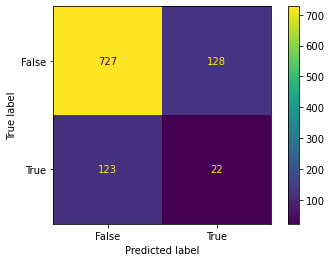

In [91]:
plot_confusion_matrix(dummy_clf, X_test, y_test);
plt.savefig('images/dummy_confusion.jpeg', bbox_inches='tight')

$\begin{bmatrix}
TN & FP \\
FN & TP
\end{bmatrix}$

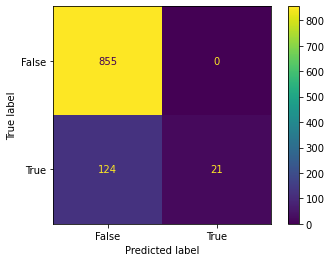

In [90]:
plot_confusion_matrix(final_model, X_test, y_test);
plt.savefig('images/final_confusion.jpeg', bbox_inches='tight')

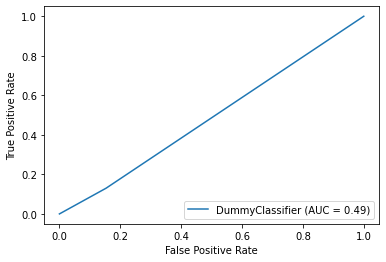

In [92]:
plot_roc_curve(dummy_clf, X_train, y_train);
plt.savefig('images/dummy_roc.jpeg', bbox_inches='tight')

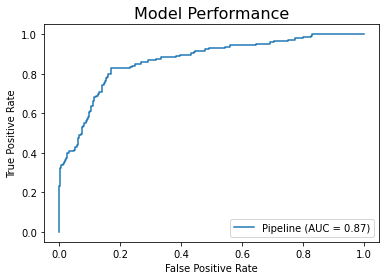

In [89]:
roc_plot = plot_roc_curve(final_model, X_test, y_test)
ax = roc_plot.ax_
ax.set_title('Model Performance', fontsize=16)

# save plot
plt.savefig('images/final_roc.jpeg', bbox_inches='tight')

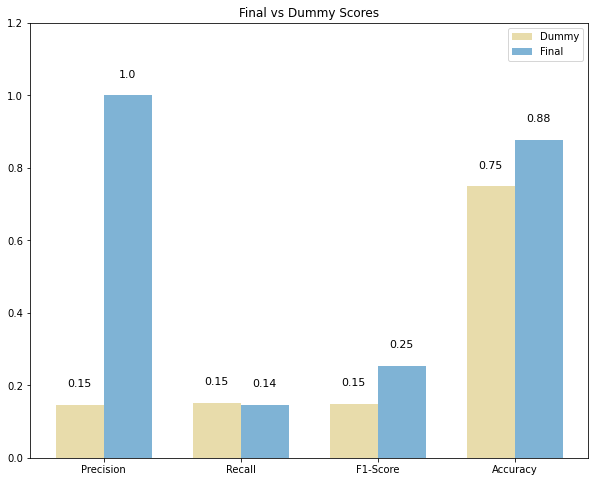

In [18]:
#plotting Dummy scores vs final model scores
dummy_model = DummyClassifier(strategy='stratified', random_state=42)
dummy_model.fit(X_train, y_train)



dummy_scores = [precision_score(y_test, dummy_model.predict(X_test)), recall_score(y_test, dummy_model.predict(X_test)), f1_score(y_test, dummy_model.predict(X_test)), accuracy_score(y_test, dummy_model.predict(X_test))]
final_scores = [precision_score(y_test, final_model.predict(X_test)), recall_score(y_test, final_model.predict(X_test)), f1_score(y_test, final_model.predict(X_test)), accuracy_score(y_test, final_model.predict(X_test))]




labels = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
x = np.arange(len(labels))
width = 0.35




fig, ax = plt.subplots(figsize=(10, 8))
dummy_bars = ax.bar(x - width/2, dummy_scores, width, label='Dummy', color='#E8DCAB')
final_bars = ax.bar(x + width/2, final_scores, width, label='Final', color='#7FB3D5')




ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()




for i, bar in enumerate(dummy_bars):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, round(bar.get_height(), 2), ha='center', fontsize=11)
    ax.text(final_bars[i].get_x() + final_bars[i].get_width() / 2, final_bars[i].get_height() + 0.05, round(final_bars[i].get_height(), 2), ha='center', fontsize=11)




plt.title('Final vs Dummy Scores')
plt.ylim(top=1.2); ## Adding padding to the top of the plot


plt.savefig('images/model_vs_stats.jpeg', bbox_inches = "tight")

C:\Users\raxmo\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


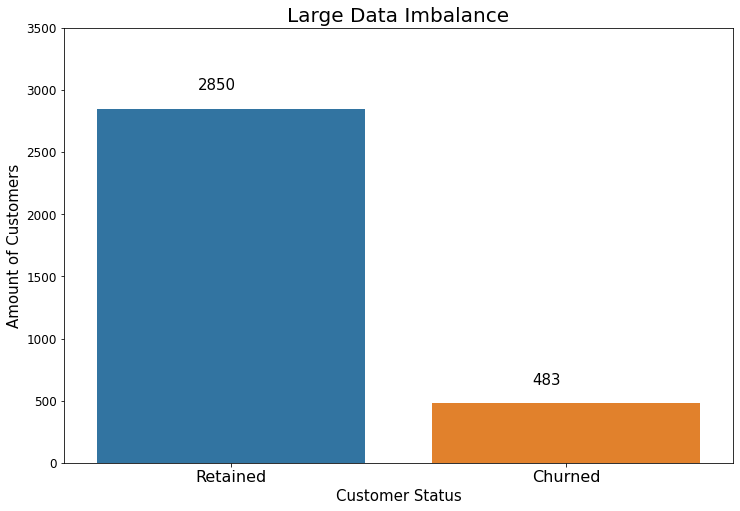

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.countplot(df['churn'])
plt.title('Large Data Imbalance', fontsize=20)
plt.xlabel('Customer Status', fontsize=15)
plt.ylabel('Amount of Customers', fontsize=15)
plt.xticks([0, 1], ['Retained', 'Churned'], fontsize=16)

plt.yticks(fontsize=12) # increases y tick labels fontsize
plt.ylim([0, 3500]) # sets the range of y axis
plt.text(-0.1, 3000, '2850', fontsize=15)
plt.text(0.9, 630, '483', fontsize=15); # adds text to y axis to show values

plt.savefig('images/large_imbalance.jpeg', bbox_inches = "tight")

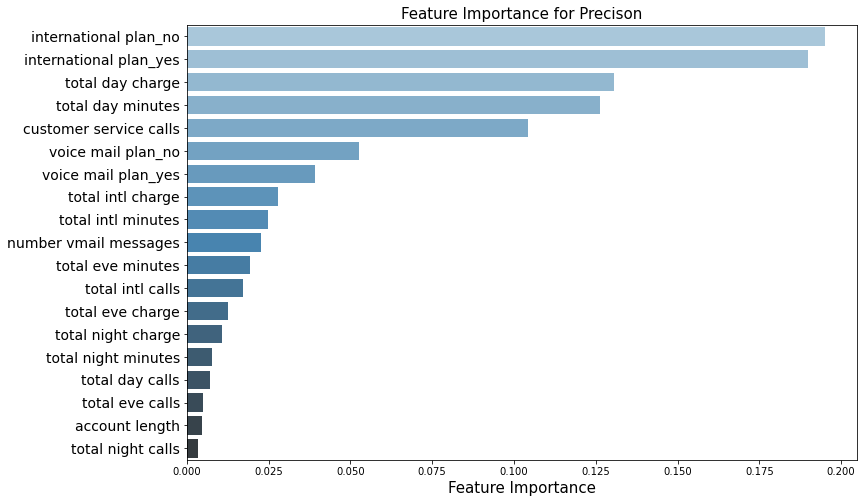

In [19]:
# Plotting the features
importance = final_model.named_steps['xtra'].feature_importances_
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(12,8))
sns.barplot(x=importance[indices], y=feature_names[indices], palette="Blues_d")

plt.xlabel('Feature Importance', fontsize=15)
plt.title('Feature Importance for Precison', fontsize=15)
plt.yticks(fontsize=14);

plt.savefig('images/feature_importance.jpeg', bbox_inches = "tight")

# Feature Inference and visualization